In [244]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

In [245]:
data = pd.read_csv("data.csv", sep=";")

In [246]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


 job : type of job \
 marital : marital status \
 default: has credit in default \
 housing: has housing loan \
 loan: has personal loan \
 contact: contact communication type \
 month: last contact month of year \
 dayofweek: last contact day of the week \
 duration: last contact duration, in seconds \
 campaign: number of contacts performed during this campaign and for this client \
 pdays: number of days that passed by after the client was last contacted from a previous campaign \
 previous: number of contacts performed before this campaign and for this client \
 poutcome: outcome of the previous marketing campaign \
 emp.var.rate: employment variation rate \
 cons.price.idx: consumer price index \
 cons.conf.idx: consumer confidence index \
 euribor3m: euribor 3 month rate \
 nr.employed: number of employees

`duration` should be removed - it is known after the call, and we want to predict before calling

In [247]:
data = data.drop("duration", axis=1)

Columns with `yes` & `no` values should be converted to bool

In [248]:
print(data.shape)
data.describe()

(41188, 20)


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Features are in different scales

In [249]:
numeric_features = data.select_dtypes(include=[np.number])
categorical_features = data.select_dtypes(include=[object]).drop("y", axis=1)
print(numeric_features.shape)
print(categorical_features.shape)

(41188, 9)
(41188, 10)


In [250]:
categorical_features.describe(include=object)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563


In [251]:
numeric_features.skew() # 0 for normal distribution: shift of distribution on x-axis

age               0.784697
campaign          4.762507
pdays            -4.922190
previous          3.832042
emp.var.rate     -0.724096
cons.price.idx   -0.230888
cons.conf.idx     0.303180
euribor3m        -0.709188
nr.employed      -1.044262
dtype: float64

In [252]:
numeric_features.kurt() # 3 for normal distribution: how high are tails of distribution chart

age                0.791312
campaign          36.979795
pdays             22.229463
previous          20.108816
emp.var.rate      -1.062632
cons.price.idx    -0.829809
cons.conf.idx     -0.358558
euribor3m         -1.406803
nr.employed       -0.003760
dtype: float64

`cons.conf.idx` has distribution close to normal
Despite that, all features should be scaled

In `pdays`, `999` represents `null` and must be replaced

<AxesSubplot:>

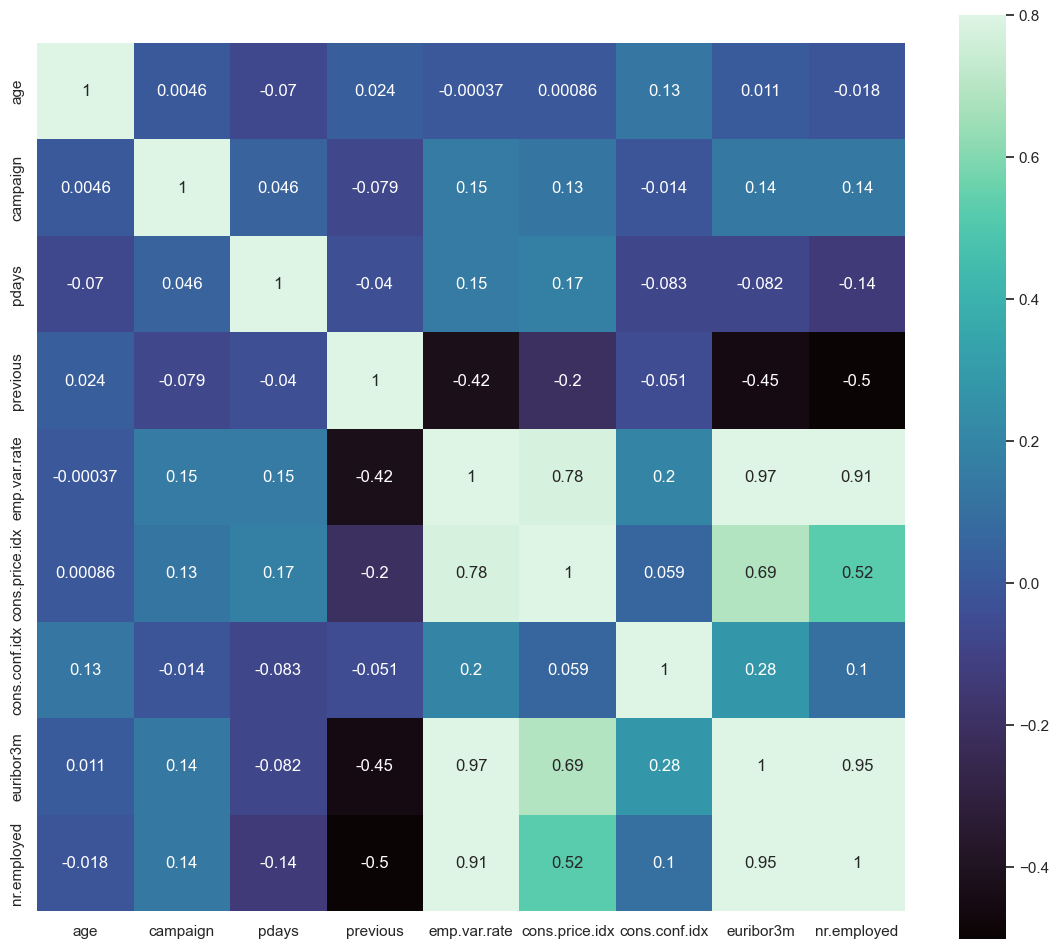

In [253]:
numeric_features.loc[numeric_features["pdays"] == 999, "pdays"] = None

correlation_matrix = numeric_features.corr()
plt.subplots(figsize = (14,12))
sns.heatmap(correlation_matrix,square = True,  vmax=0.8,annot=True, cmap="mako")

`cons.price.idx` and `emp.var.rate` are noticeably correlated positively \
`nr.employed` and `euribor3m` are less correlated positively

`cons.conf.idx` and `emp.var.rate` are noticeably correlated negatively, they might be some kind of opposite coefficients \
`cons.price.idx` and `nr.employed` are less correlated negatively \
`cons.price.idx` and `cons.conf.idx` are less correlated negatively

Removing `cons.price.idx` could be considered - it is strongly correlated with 2 features and almost not at all with rest

<AxesSubplot:xlabel='cons.price.idx', ylabel='cons.conf.idx'>

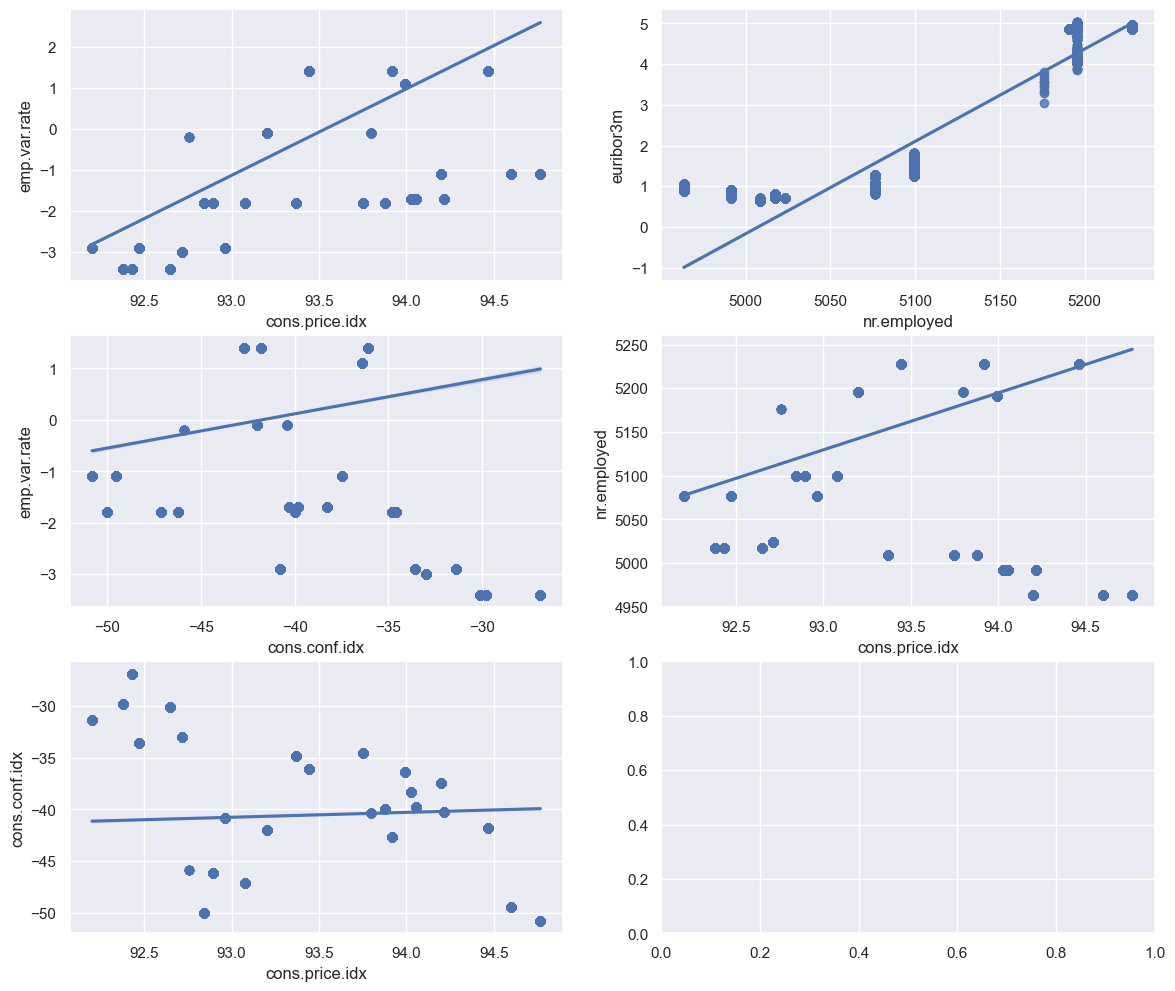

In [254]:
_, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(14,12))

sns.regplot(x='cons.price.idx',y = 'emp.var.rate',data = numeric_features,fit_reg=True, ax=ax1)
sns.regplot(x='nr.employed',y = 'euribor3m',data = numeric_features,fit_reg=True, ax=ax2)
sns.regplot(x='cons.conf.idx',y = 'emp.var.rate',data = numeric_features,fit_reg=True, ax=ax3)
sns.regplot(x='cons.price.idx',y = 'nr.employed',data = numeric_features,fit_reg=True, ax=ax4)
sns.regplot(x='cons.price.idx',y = 'cons.conf.idx',data = numeric_features,fit_reg=True, ax=ax5)

`nr.employed` and `euribor3m` have exponential relation, others are linear

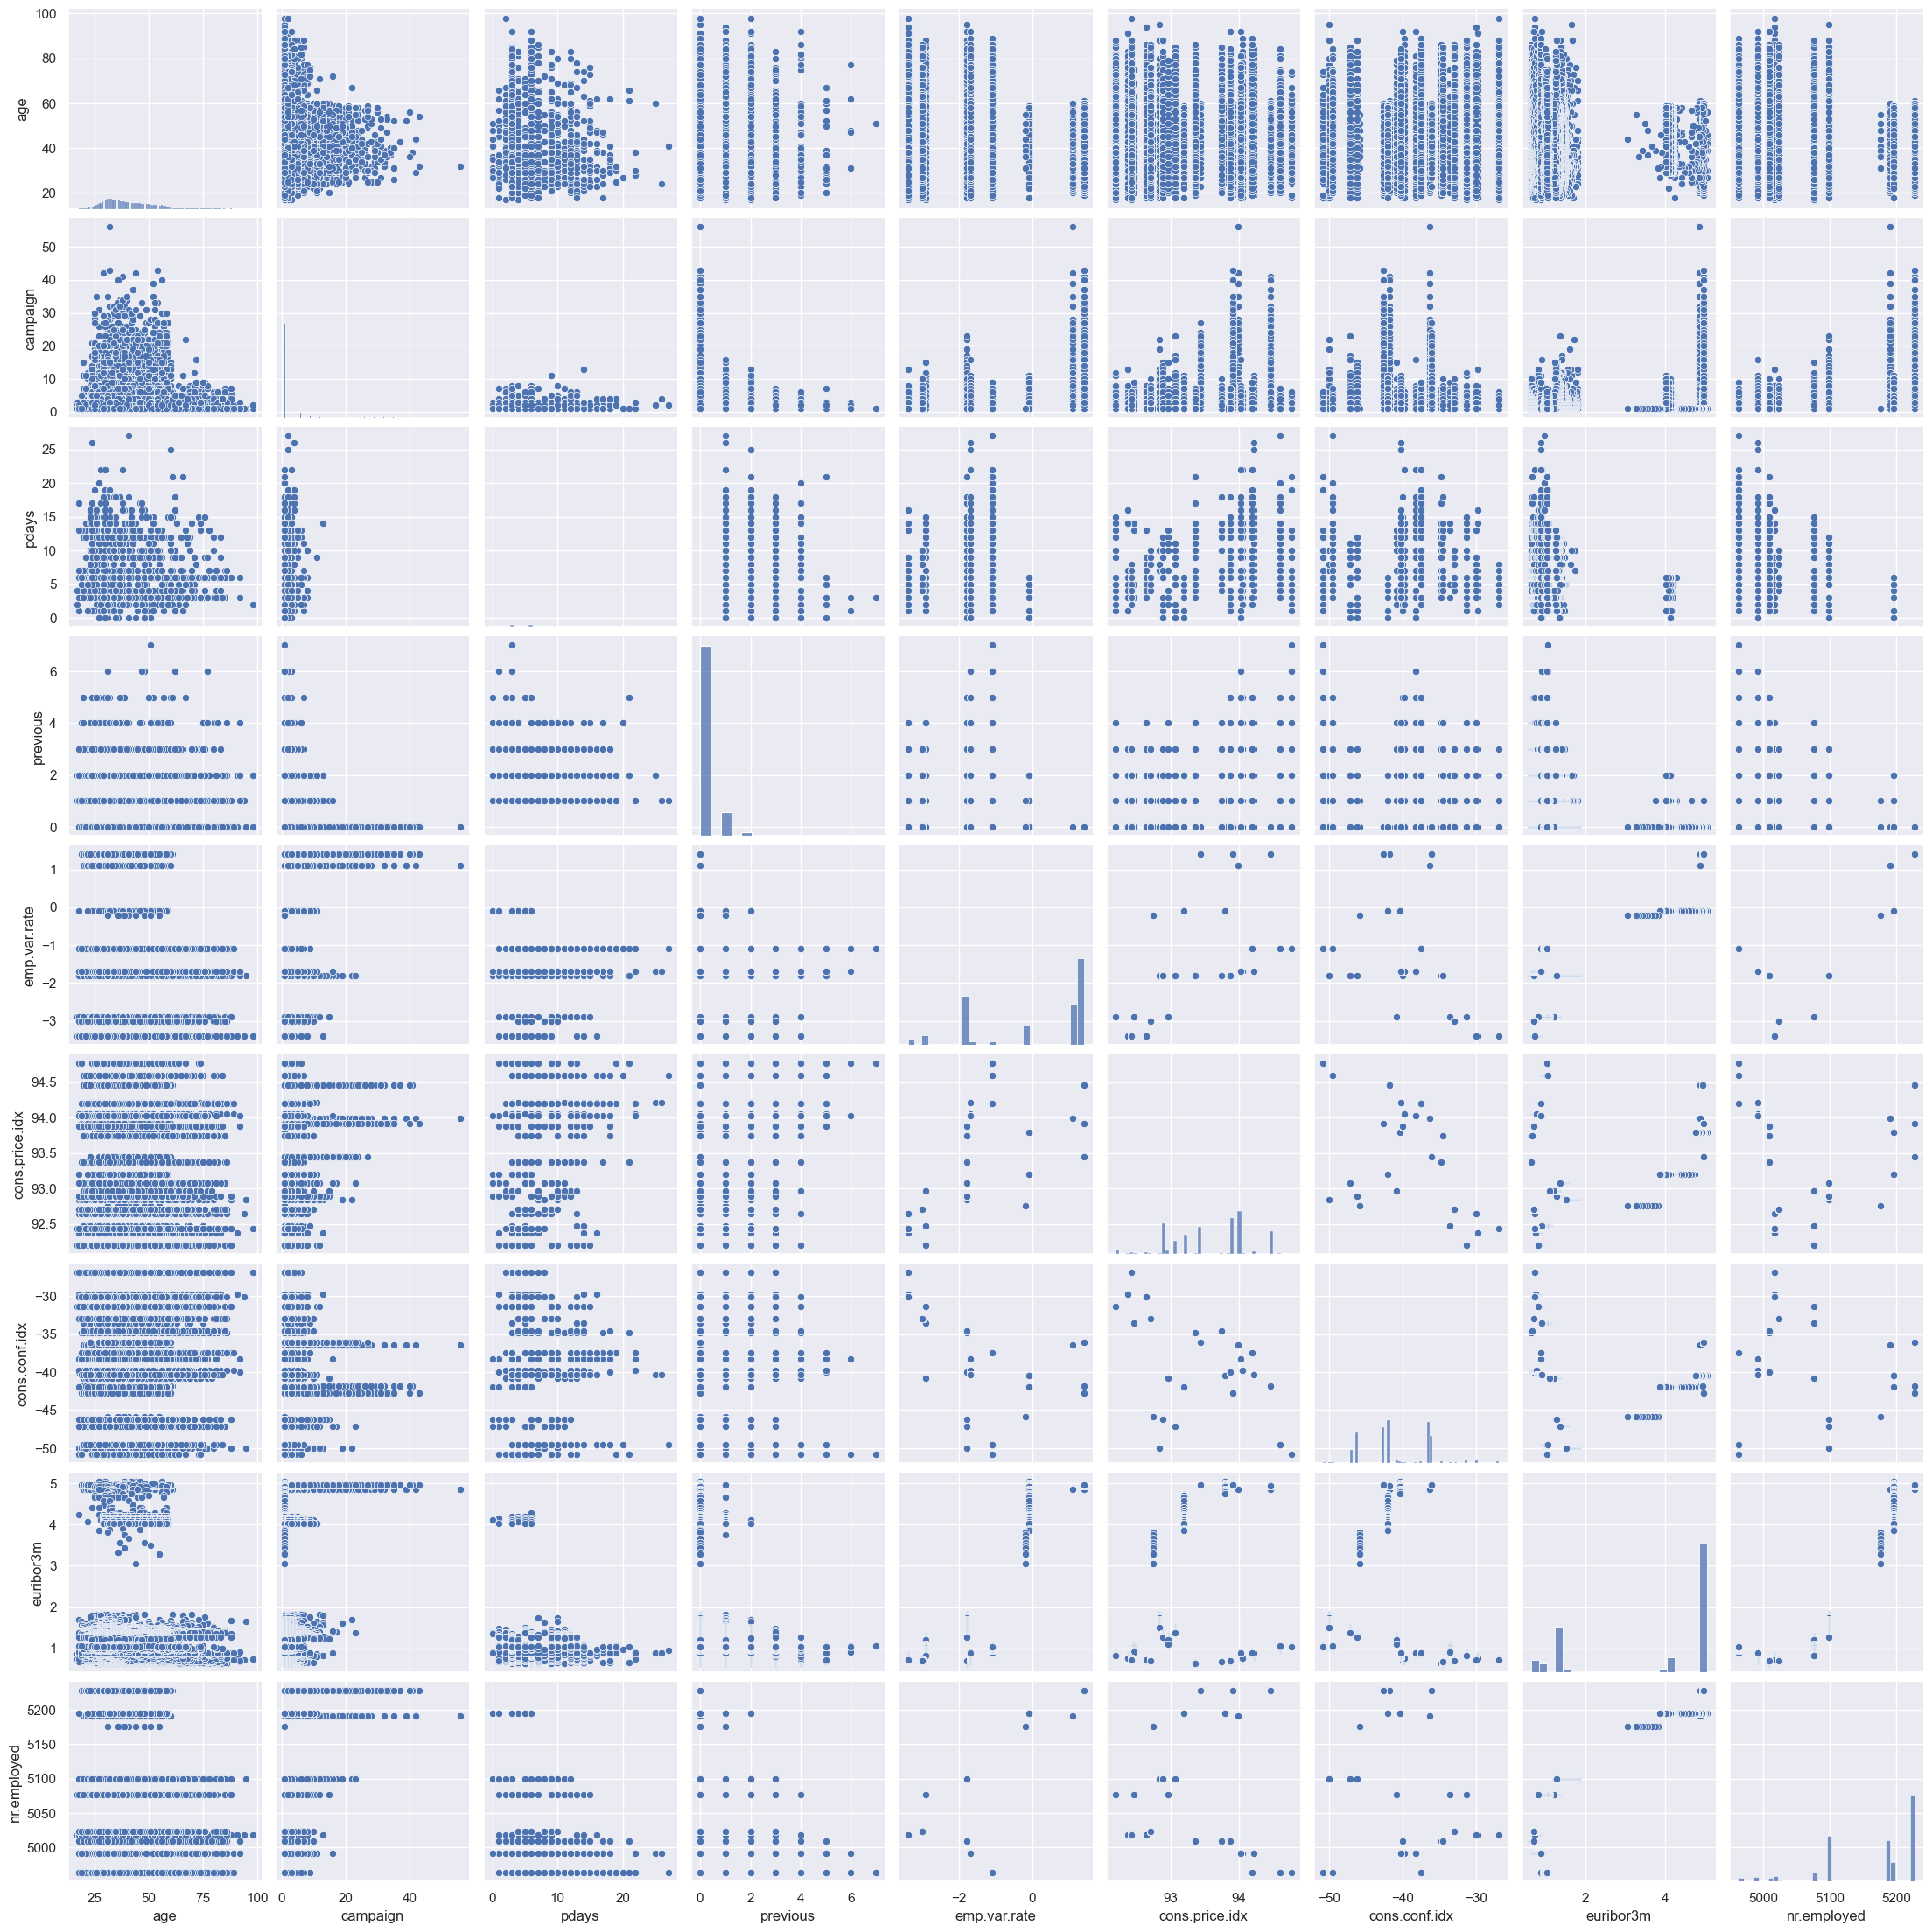

In [255]:
sns.set()
sns.pairplot(numeric_features, kind="scatter")
plt.show()

There seems to be linear lower bound in relation of `cons.price.ixd` and `pdays` - minimal "value" of client raises with time without answer since campaign

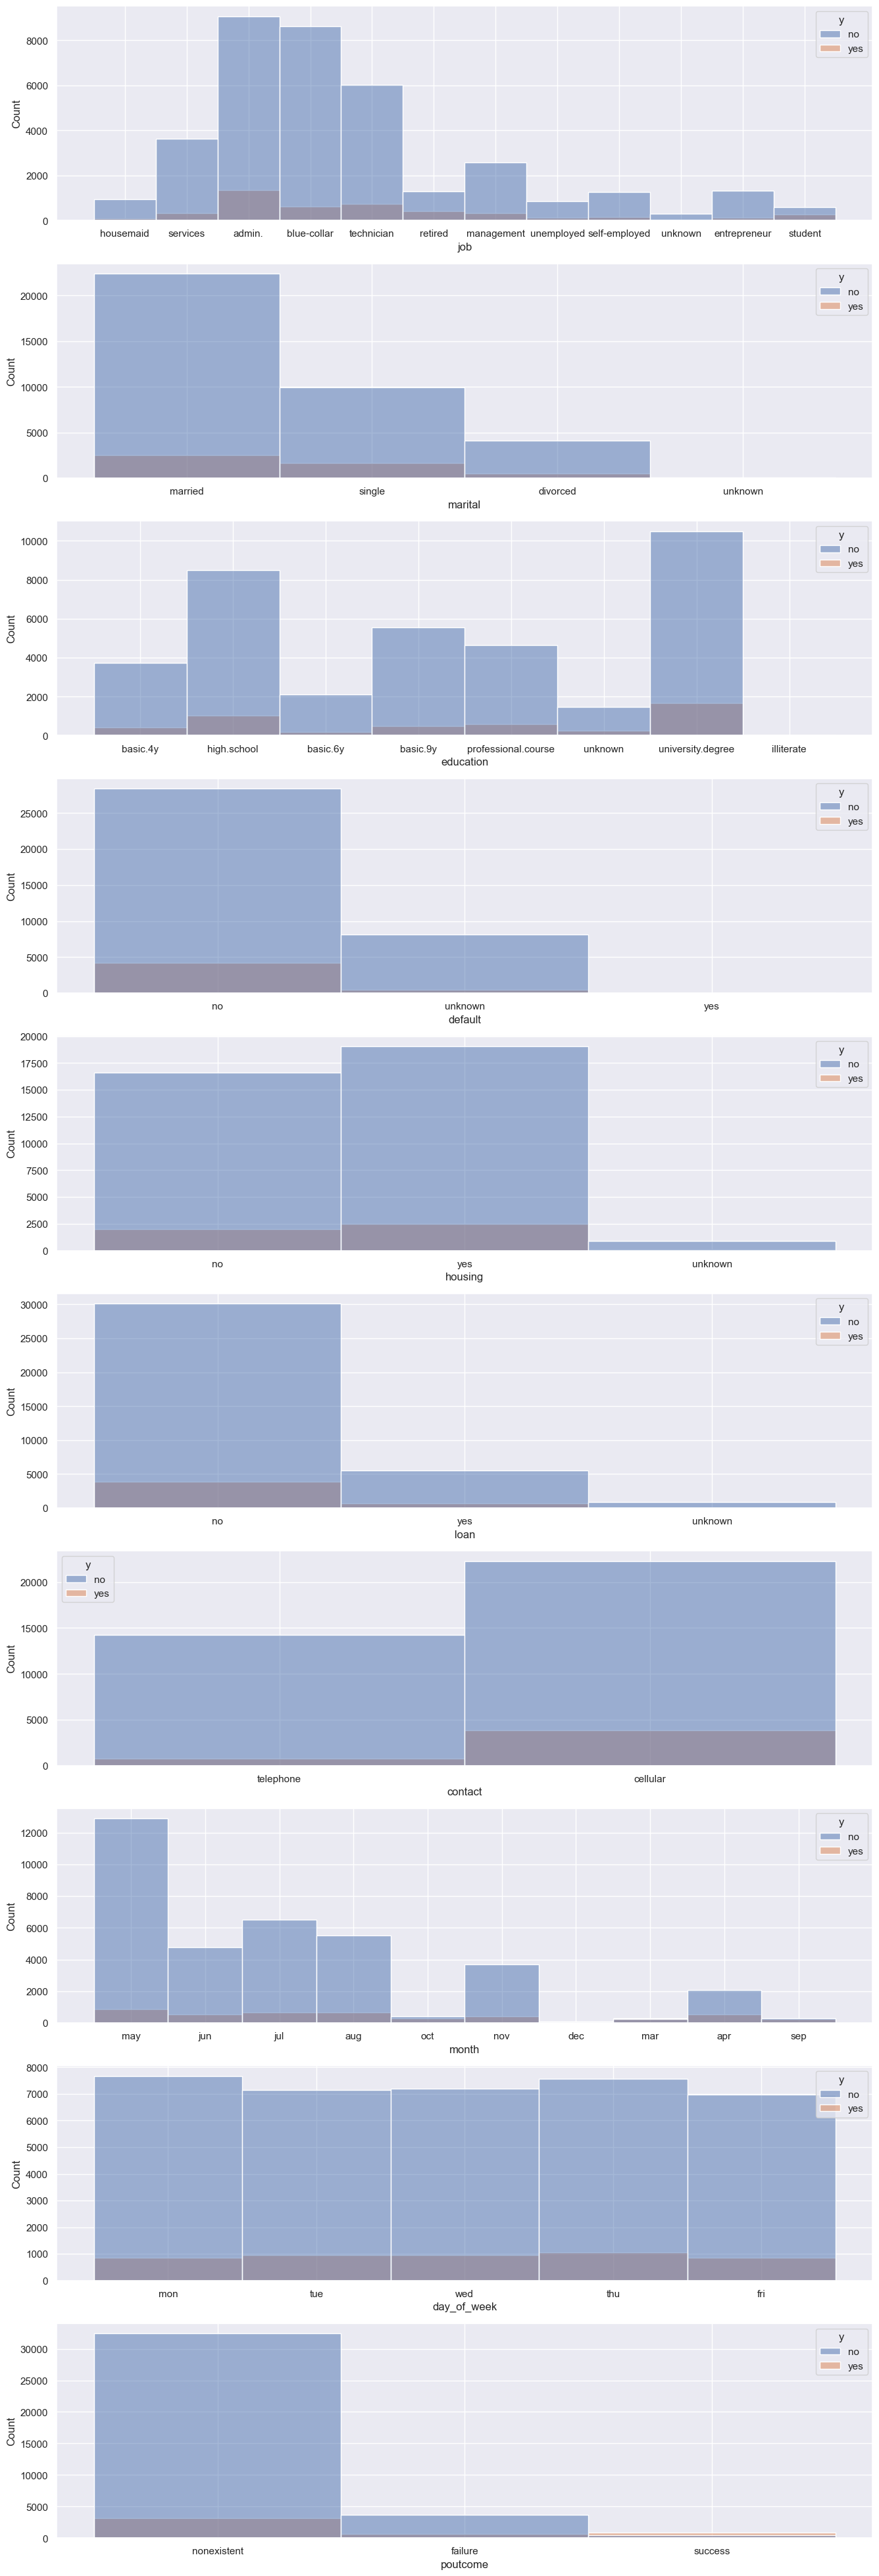

In [256]:
_, axes = plt.subplots(nrows=10, ncols=1, figsize=(16,50))

for column, ax in zip(categorical_features.columns, axes):
    sns.histplot(x=column, data=data, stat="count", ax=ax, hue="y")

Worth noticing: \
Many features have `unknown` values representing `null` \
Most targets have well paid job and at least secondary education, it might explain low percentage of targets with loan \
There is a noticeable increase of number of contacts in May - marketing campaign might have taken place then \
There is a noticeable percentage of married targets (distribution of martial status in the country could be checked)

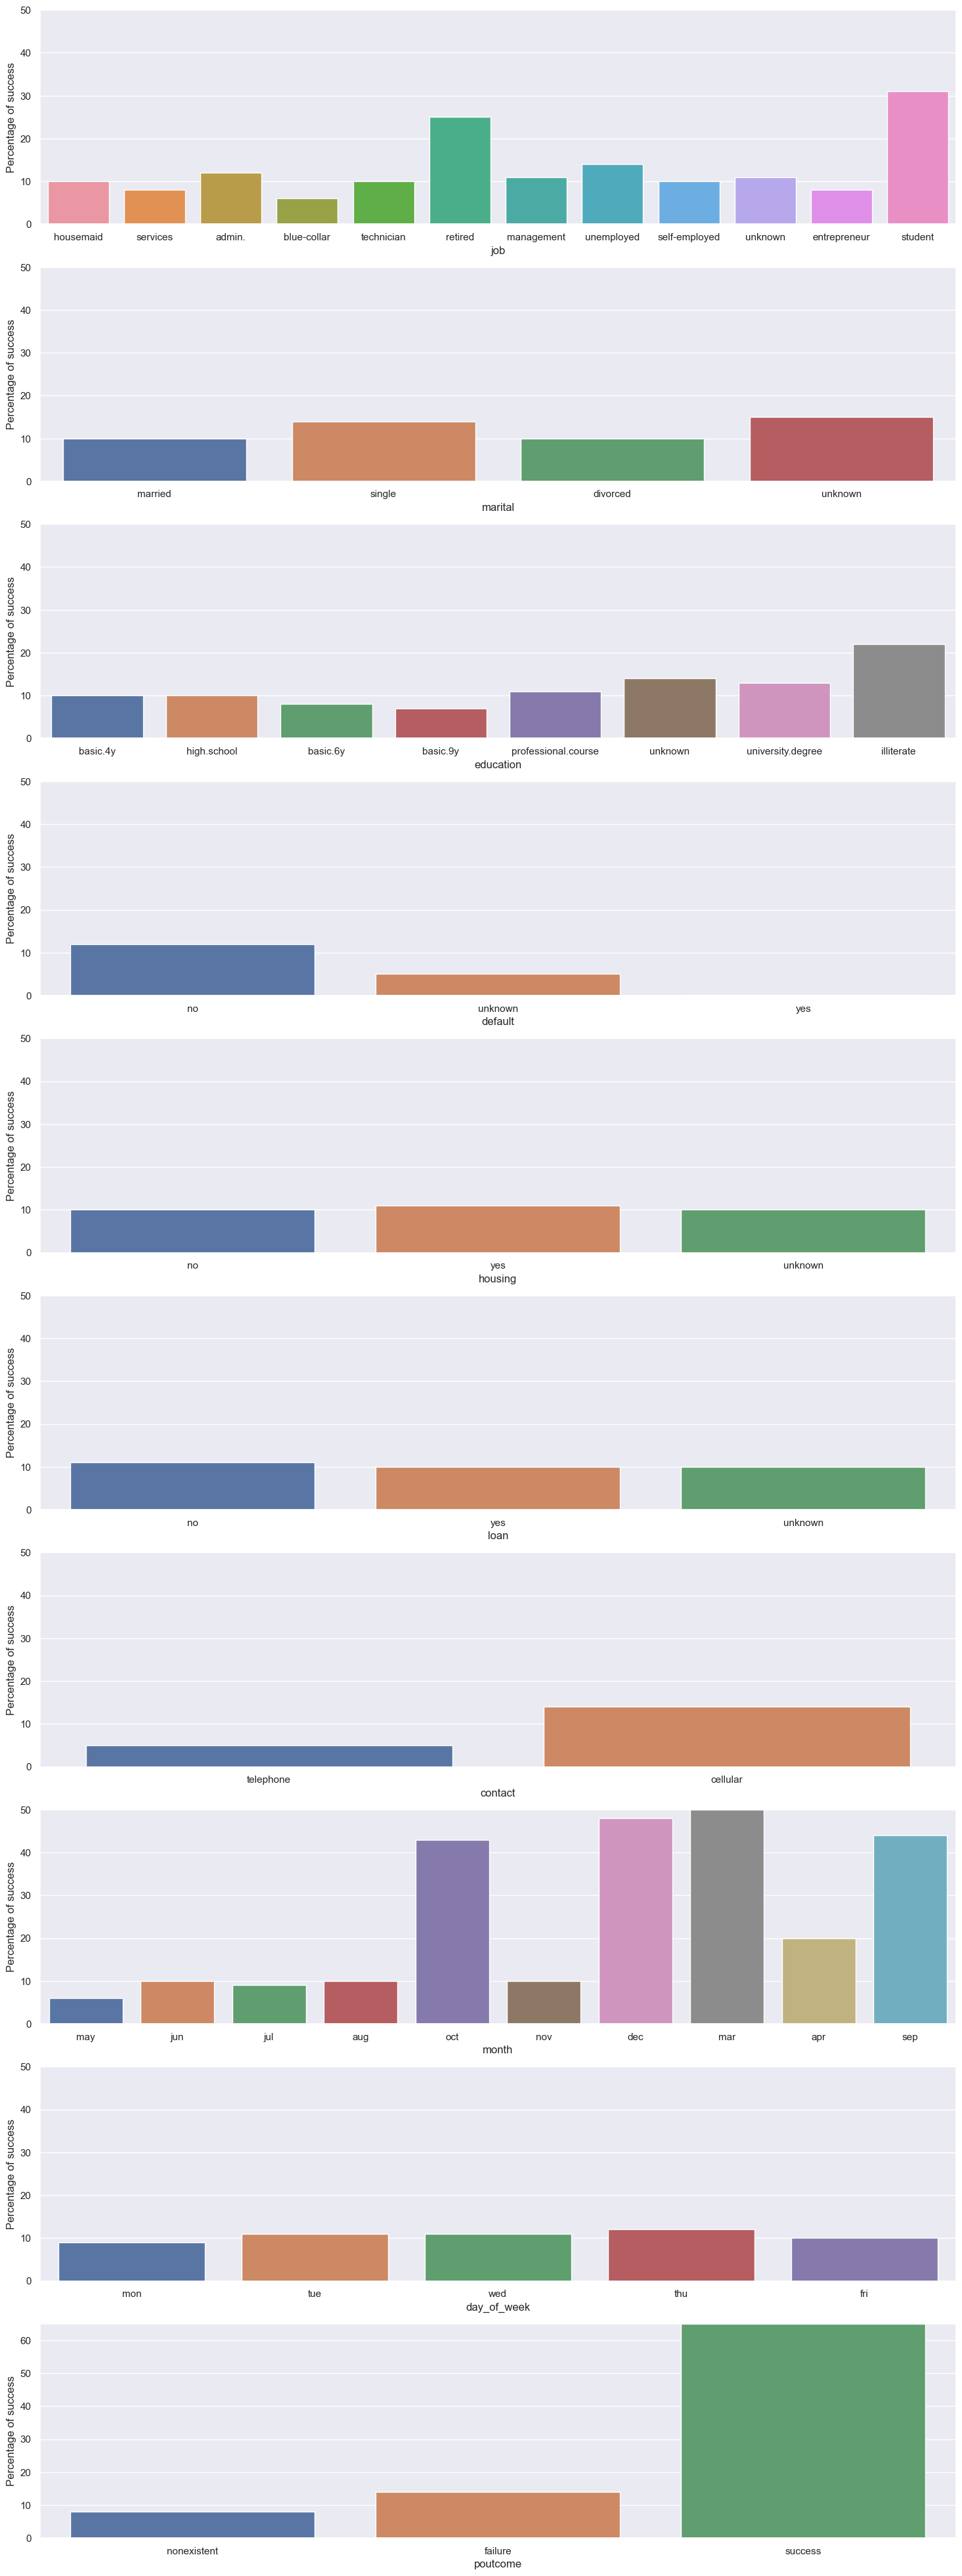

In [257]:
_, axes = plt.subplots(nrows=10, ncols=1, figsize=(18,50))

for column, ax in zip(categorical_features.columns, axes):
    percentages_of_success = []

    for value in categorical_features[column].unique():
        value_occurrences_number = len(data[data[column] == value])
        number_of_successes_when_value = len(data[(data[column] == value) & (data["y"] == "yes")])
        percentage_of_success =  int(number_of_successes_when_value / value_occurrences_number * 100)
        percentages_of_success.append((value, percentage_of_success))

    data_with_percentage = pd.DataFrame(percentages_of_success, columns=[column, "Percentage of success"])
    ax.set_ylim(0, max([x[1] for x in percentages_of_success] + [50])) # Keep charts in same scale
    sns.barplot(y="Percentage of success", x=column, data=data_with_percentage,  ax=ax, )

Worth noticing: \
No interest among targets with loan
High success percentage among targets convinced during previous campaign \
The Highest success percentage in months with the lowest number of contacts: \
probably bank was only contacting promising targets or those were clients unaware of campaign calling by themselves

<AxesSubplot:xlabel='y', ylabel='Percent'>

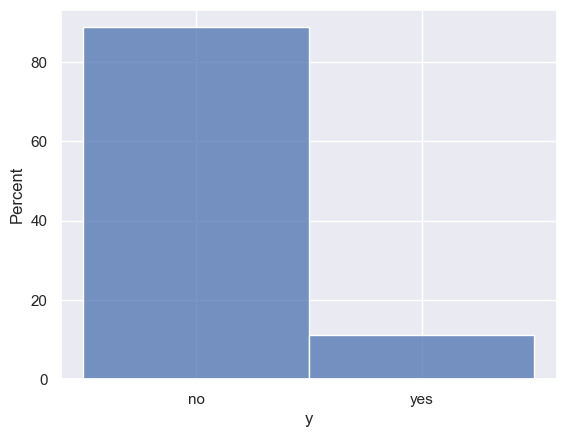

In [258]:
sns.histplot(data=data, x="y", stat="percent")